In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config=ConfigProto()
config.gpu_options.allow_growth=True
session=InteractiveSession(config=config)

import tensorflow as tf
import tensorflow_addons as tfa
from tf.keras.layers import Activation,Dense,Input,concatenate
from tf.keras.layers import Conv2D, Flatten, Conv2DTranspose, LeakyReLU, BatchNormalization
from tf.keras.optimizers import RMSprop, Adam
from tf.keras.models import Model, load_model, Sequential
from tf.keras.layers import Reshape, Dropout,ZeroPadding2D,Add, add
from tensorflow.keras import backend as k
from tensorflow.keras.utils import plot_model
import scipy
import matplotlib.pyplot as plt
import numpy as np
import os
import other_utils

ModuleNotFoundError: No module named 'tf'

In [15]:
def build_generator_unet(input_shape,output_shape,kernel_size,gen_n_filters):
    def encoder(layer_input,filters,strides=2,activation='relu'):
        conv=Conv2D(filters,kernel_size=kernel_size,strides=strides,padding='same')
        d=tfa.InstanceNormalization(axis=-1, center=False,scale=False)(layer_input)
        #d=BatchNormalization(axis=-1)(layer_input)
        if activation=='relu':
            d=Activation('relu')(d)
        else:
            d=LeakyReLU(alpha=0.2)(d)
        d=conv(d)
        return d
    
    def decoder(layer_input,concate_input,filters,activation='relu'):
        conv=Conv2DTranspose(filters,kernel_size=kernel_size,strides=2,padding='same')
        u=tfa.InstanceNormalization(axis=-1, center=False,scale=False)(layer_input)
        #u=BatchNormalization(axis=-1)(layer_input)
        if activation=='relu':
            u=Activation('relu')(u)
        else:
            u=LeakyReLU(alpha=0.2)(u)
        u=conv(u)
        u=concatenate([u,concate_input])
        return u
    
    img=Input(shape=input_shape)
    channels=int(output_shape[-1])
    
    d1=encoder(img, gen_n_filters,strides=1,activation='notrelu')
    d2=encoder(d1,gen_n_filters*2,activation='notrelu')
    d3=encoder(d2, gen_n_filters*4,activation='notrelu')
    d4=encoder(d3, gen_n_filters*8,activation='notrelu')
    u1=decoder(d4,d3, gen_n_filters*4)
    u2=decoder(u1,d2, gen_n_filters*2)
    u3=decoder(u2,d1, gen_n_filters)
    
    output=Conv2DTranspose(channels,kernel_size=kernel_size, strides=1, padding='same', activation='relu')(u3)
    generator=Model(img,output)
    return generator
    

In [16]:
def build_generator_resnet(input_shape,kernel_size,gen_n_filters,output_shape=None):
    def conv7s1(layer_input,filters,final):
        #y=ReflectionPadding2D(padding=(3,3))(layer_input)
        #y=Conv2D(filters,kernel_size=(7,7),strides=1,padding='valid')(y)
        y=Conv2D(filters,kernel_size=(7,7),strides=1,padding='same')(layer_input)
        if final:
            y=Activation('tanh')(y)
        else:
            y=tfa.InstanceNormalization(axis=-1, center=False,scale=False)(y)
            y=Activation('relu')(y)
        return y
    def encoder(layer_input,filters):
        y=Conv2D(filters,kernel_size=kernel_size,strides=2,padding='same')(layer_input)
        y=tfa.InstanceNormalization(axis=-1, center=False,scale=False)(y)
        y=Activation('relu')(y)
        return y
    def residual(layer_input,filters):
        short_cut=layer_input
        #y=ReflectionPadding2D(padding=(1,1))(layer_input)
        y=Conv2D(filters,kernel_size=kernel_size,strides=1,padding='same')(layer_input)
        y=tfa.InstanceNormalization(axis=-1, center=False,scale=False)(y)
        y=Activation('relu')(y)
        
        #y=ReflectionPadding2D(padding=(1,1))(y)
        y=Conv2D(filters,kernel_size=kernel_size,strides=1,padding='same')(y)
        y=tfa.InstanceNormalization(axis=-1, center=False,scale=False)(y)
                
        return add([short_cut,y])
    
    def decoder(layer_input,filters):
        y=Conv2DTranspose(filters,kernel_size=kernel_size,strides=2,padding='same')(layer_input)
        y=tfa.InstanceNormalization(axis=-1, center=False,scale=False)(y)
        y=Activation('relu')(y)
        return u
    
    img=Input(shape=input_shape)
    channels=int(output_shape[-1])
    y=conv7s1(img,gen_n_filters,False)
    y=encoder(y,gen_n_filters*2)
    y=encoder(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=decoder(y,gen_n_filters*2)
    y=decoder(y,gen_n_filters)
    output=conv7s1(y,channels,True)
    generator=Model(img,output)
    return generator        

In [17]:
def build_discriminator(input_shape,kernel_size,dis_n_filters,patchgan=False):
    def conv(layer_input,filters,strides=2):
        conv=Conv2D(filters,kernel_size=kernel_size,strides=strides,padding='same')
        y=LeakyReLU(0.2)(layer_input)
        y=conv(y)
        return y
    img=Input(shape=input_shape)
    y=conv(img,dis_n_filters)
    y=conv(y,dis_n_filters*2)
    y=conv(y,dis_n_filters*4)
    y=conv(y,dis_n_filters*8)
    if patchgan:
        y=LeakyReLU(alpha=0.2)(y)
        output=Conv2D(1,kernel_size=kernel_size,strides=1,padding='same')(y)
    else:
        y=Flatten()(y)
        y=Dense(1)(y)
        output=Activation('linear')(y)
    discriminator=Model(img,output)
    return discriminator
            

In [18]:
def build_cyclegan(shapes,dis_n_filters,gen_n_filters,kernel_size,unet=True,patchgan=False,identity=False):
    A_shape, B_shape=shapes
    d_A=build_discriminator(A_shape,kernel_size,dis_n_filters,patchgan=patchgan)
    d_B=build_discriminator(B_shape,kernel_size,dis_n_filters,patchgan=patchgan)
    d_A.summary()
    d_B.summary()
    d_A.compile(loss='mse',optimizer=RMSprop(lr=2e-4,decay=6e-8))
    d_B.compile(loss='mse',optimizer=RMSprop(lr=2e-4,decay=6e-8))
    #d_A.summary()
    #d_B.summary()
    if unet:
        g_AB=build_generator_unet(A_shape,B_shape,kernel_size,gen_n_filters)
        g_BA=build_generator_unet(B_shape,A_shape,kernel_size,gen_n_filters)
    else:
        g_AB=build_generator_resnet(A_shape,B_shape,kernel_size,gen_n_filters)
        g_BA=build_generator_resnet(B_shape,A_shape,kernel_size,gen_n_filters)
    
    d_A.trainable=False
    d_B.trainable=False
    g_AB.summary()
    g_BA.summary()
    img_A=Input(shape=A_shape)
    img_B=Input(shape=B_shape)
    fake_A=g_BA(img_B)
    fake_B=g_AB(img_A)
    valid_A=d_A(fake_A)
    valid_B=d_B(fake_B)
    recons_A=g_BA(fake_B)
    recons_B=g_AB(fake_A)
    
    if identity:
        img_A_id=g_BA(img_A)
        img_B_id=g_AB(img_B)
        inputs=[img_A, img_B]
        outputs=[valid_A, valid_B, recons_A, recons_B, img_A_id, img_B_id]
        loss=['mse','mse','mae','mae','mae','mae']
        loss_weights=[1.,1.,10.,10.,0.5,0.5]
    else:
        inputs=[img_A,img_B]
        outputs=[valid_A, valid_B, recons_A, recons_B]
        loss=['mse','mse','mae','mae']
        loss_weights=[1.,1.,10.,10.]
    
    adv=Model(inputs, outputs)
    adv.compile(loss=loss, optimizer=RMSprop(lr=2e-4,decay=6e-8), loss_weights=loss_weights)
    #adv.summary()
    return d_A, d_B, g_AB, g_BA, adv        

((32, 32, 1), (32, 32, 3))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 32, 32, 1)         0         
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 32)        320       
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 4, 4, 128)   

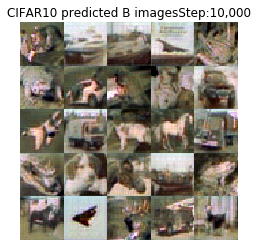

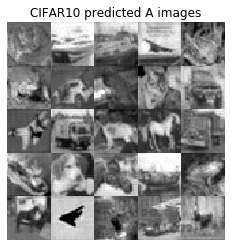

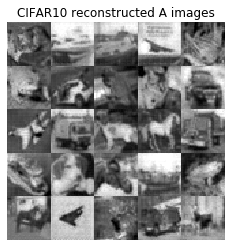

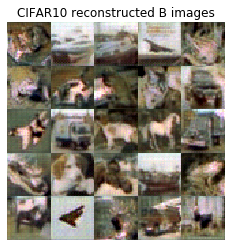

20000:[d_A loss:0.160590]:[d_B loss:0.153212][adv loss:4.657326]


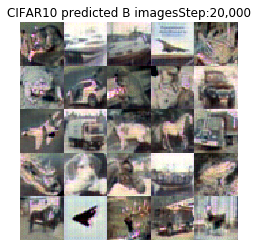

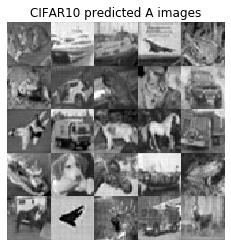

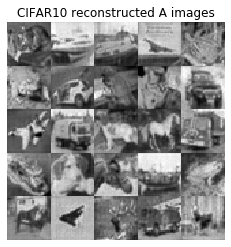

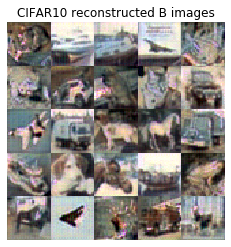

30000:[d_A loss:0.267383]:[d_B loss:0.116963][adv loss:4.245390]


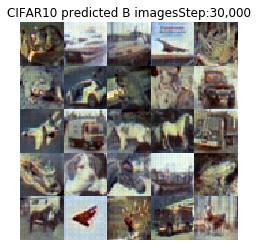

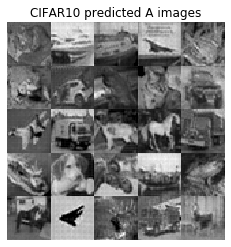

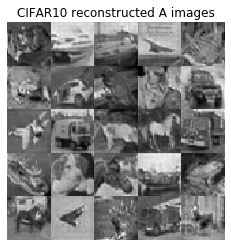

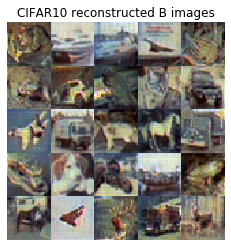

40000:[d_A loss:0.429488]:[d_B loss:0.218387][adv loss:4.230904]


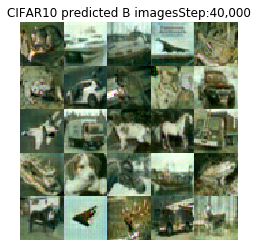

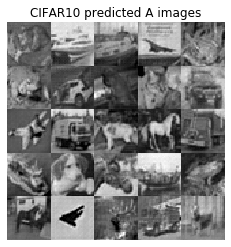

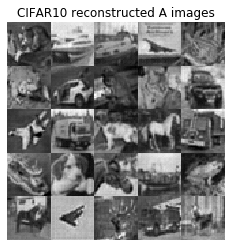

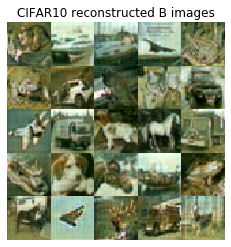

50000:[d_A loss:0.130725]:[d_B loss:0.194827][adv loss:3.756451]


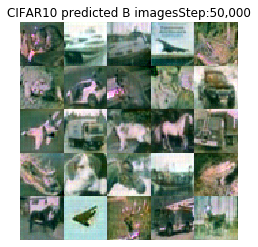

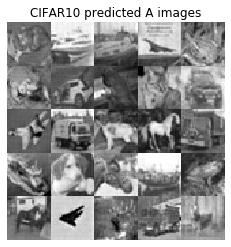

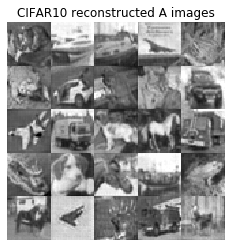

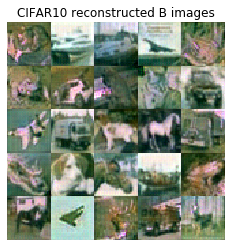

60000:[d_A loss:0.207970]:[d_B loss:0.136157][adv loss:4.521077]


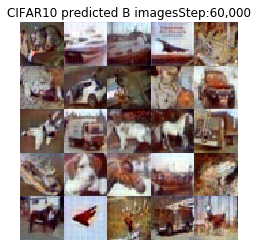

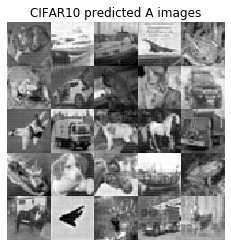

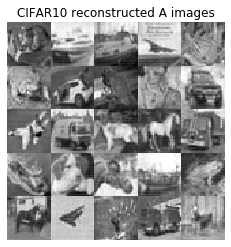

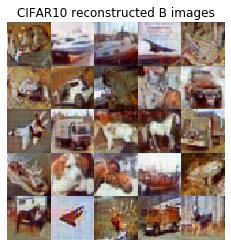

70000:[d_A loss:0.380856]:[d_B loss:0.046437][adv loss:3.543499]


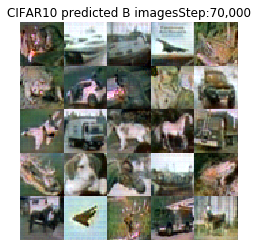

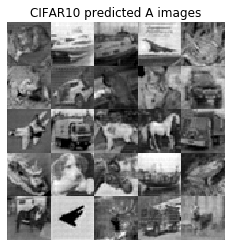

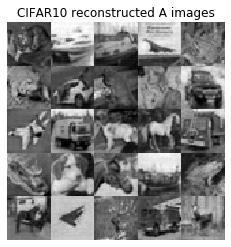

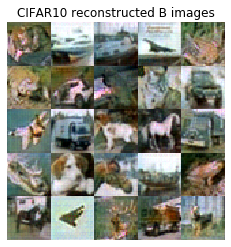

80000:[d_A loss:0.201557]:[d_B loss:0.348996][adv loss:3.183197]


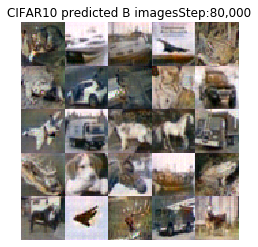

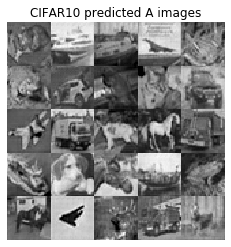

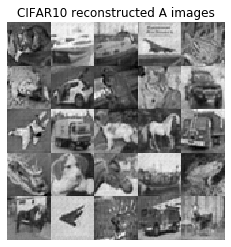

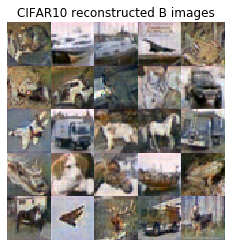

90000:[d_A loss:0.199653]:[d_B loss:0.190379][adv loss:3.002814]


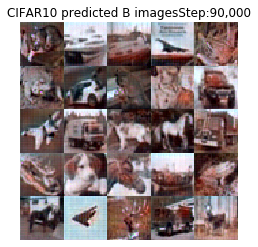

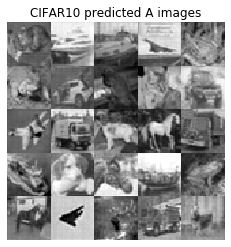

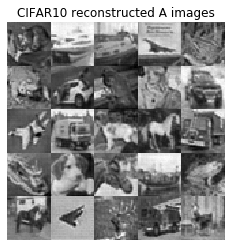

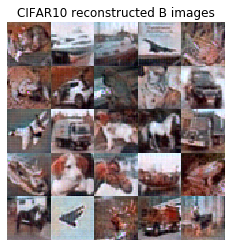

100000:[d_A loss:0.280637]:[d_B loss:0.235494][adv loss:3.424403]


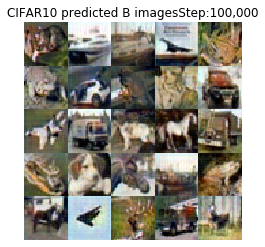

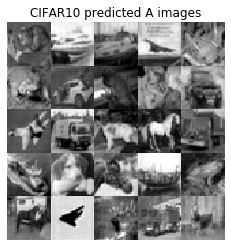

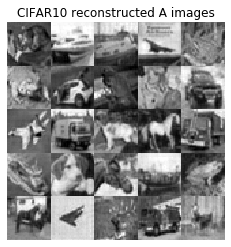

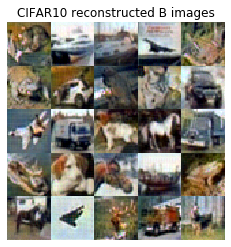

In [19]:
import cifar10_utils
batch_size=2
train_steps=100000
patchgan=True
identity=False
save_interval=10000
kernel_size=3
gen_n_filters=32
dis_n_filters=32


data, shapes=cifar10_utils.load_cifar10()
print(shapes)
A_data,B_data,test_A_data,test_B_data=data
titles=('CIFAR10 predicted A images', "CIFAR10 predicted B images", 'CIFAR10 reconstructed A images','CIFAR10 reconstructed B images')
B_size=int(B_data.shape[0])
A_size=int(A_data.shape[0])

models=build_cyclegan(shapes,gen_n_filters,dis_n_filters,kernel_size,patchgan=patchgan,identity=identity)
d_A,d_B,g_AB,g_BA,adv=models

if patchgan:
    patch=int(A_data.shape[1]/2**4)
else:
    patch=1

if patch>1:
    d_patch=(patch,patch,1)
    valid=np.ones((batch_size,)+d_patch)
    fake=np.zeros((batch_size,)+d_patch)
else:
    valid=np.ones([batch_size,1])
    fake=np.zeros([batch_size,1])
    
for step in range(train_steps):
    rand_index=np.random.randint(0,B_size,size=batch_size)
    real_B=B_data[rand_index]
    rand_index=np.random.randint(0,A_size,size=batch_size)
    real_A=A_data[rand_index]
    
    fake_B=g_AB.predict(real_A)
    fake_A=g_BA.predict(real_B)
    
    dA_loss_real=d_A.train_on_batch(real_A, valid)
    dA_loss_fake=d_A.train_on_batch(fake_A, fake)
    dA_loss=0.5*np.add(dA_loss_real,dA_loss_fake)
    log="%d:[d_A loss:%f]" % (step+1,dA_loss)
    
    dB_loss_real=d_B.train_on_batch(real_B, valid)
    dB_loss_fake=d_B.train_on_batch(fake_B, fake)
    dB_loss=0.5*np.add(dB_loss_real,dB_loss_fake)
    log='%s:[d_B loss:%f]' %(log,dB_loss)
    
    if identity:
        adv_loss=adv.train_on_batch([real_A,real_B],[valid,valid,real_A, real_B,real_A,real_B])
        log='%s[adv loss:%f]'%(log,adv_loss[0])
    else:
        adv_loss=adv.train_on_batch([real_A,real_B], [valid,valid,real_A, real_B])
        log='%s[adv loss:%f]'%(log,adv_loss[0])
    
    if (step+1)%save_interval==0:
        print(log)
        if (step+1)==train_steps:
            show=True
        else:
            show=True
    
        import other_utils
        other_utils.test_generator((g_BA, g_AB),(test_A_data,test_B_data), step=step+1, titles=titles,show=show)

In [20]:
from tf.keras.models import load_model
g_AB.save('cifar10g_AB.h5')
g_BA.save('cifar10g_BA.h5')

#generator_AB=load_model('cifar10g_AB.h5')
#generator_BA=load_model('cifar10g_BA.h5')